# **<ins>Genetic Algorithm for Knapsack Problem**

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
input_file_path = '/content/gdrive/My Drive/AI-1400/in1.txt'
# input_file_path = 'in1.txt'

# <ins>**GA Implementation**</ins>:

In [ ]:
def initialize_population(population_size, chromosome_length):
  population = [[random.randint(0,1) for i in range(chromosome_length)]for j in range(population_size)]
  return population

In [ ]:
def bit_flip_mutation(chromosome):
  
  flip_probability = 0.02
  for gen in range(len(chromosome)):
    if random.random() < flip_probability:
      chromosome[gen] = 1 - chromosome[gen]

  return chromosome

In [ ]:
# I'm not using this :)
def one_point_crossover(chromosome1, chromosome2):

  chromosome_length = len(chromosome1)

  # cross_over_probability = 0.8
  # if random.random() > cross_over_probability:
  #   return chromosome1, chromosome2

  i = random.randint(1,chromosome_length-1)
  child1 = chromosome1[0:i]+chromosome2[i:chromosome_length]
  child2 = chromosome2[0:i]+chromosome1[i:chromosome_length]

  return child1, child2

In [ ]:
def k_point_cross_over(chromosome1, chromosome2, k):

  chromosome_length = len(chromosome1)

  points = random.sample(range(chromosome_length-1), k)
  points = sorted(points)

  children = []

  for i in range(1, 2**(k+1)-1):

    child = []
    prev_point = -1

    f = "{0:0"+str(k+1)+"b}"
    code = f.format(i)

    for j in range(len(code)-1):

      if code[j] == '0':
        child = child + chromosome1[prev_point+1:points[j]+1]
      else:
        child = child + chromosome2[prev_point+1:points[j]+1]
      prev_point = points[j]

    if code[-1] == '0':
      child = child + chromosome1[prev_point+1:]
    else:
      child = child + chromosome2[prev_point+1:]

    children.append(child)

  return children

In [ ]:
def offspring_production(parents, k_for_CO, population_size):

  children = []

  for p1 in range(len(parents)):
    for p2 in range(p1+1, len(parents)):
      children = children + k_point_cross_over(parents[p1], parents[p2], k_for_CO)
      if len(children) == 3 * population_size:
        return children

  return children

In [ ]:
def fitness_function_Question1(prices, values, distances, value_decrease_rates, available_money, chromosome):
  
  chromosome_length = len(chromosome)

  values_sum = sum([chromosome[i]*(values[i]-distances[i]*value_decrease_rates[i]) for i in range(chromosome_length)])

  prices_sum = sum([chromosome[i]*prices[i] for i in range(chromosome_length)])

  penalty_rate = 2
  penalty = penalty_rate * max(prices_sum - available_money, 0)

  fitness = max(values_sum - penalty, 100)
  return fitness

In [ ]:
def fitness_proportional_select(prices, values, distances, value_decrease_rates, available_money, population, selection_count):

  chromosome_length = len(population[0])
  population_size = len(population)

  fitnesses = np.array([fitness_function_Question1(prices, values, distances, value_decrease_rates, available_money, chromosome) for chromosome in population])
  fitnesses_sum = sum(fitnesses)

  rullet_wheel = [None] * population_size

  cumulative_f = 0
  for chromosome_index in range(population_size):
    proportion = fitnesses[chromosome_index]/fitnesses_sum
    cumulative_f = cumulative_f + proportion
    rullet_wheel[chromosome_index] = cumulative_f

  #increasing this number will probably cause repetitive choices
  # precision = 10
  random_choices = np.array(random.sample(range(population_size), selection_count))
  random_choices = random_choices / population_size

  rw = np.array(rullet_wheel)

  selecteds_indices = [np.searchsorted(rw, rndm) for rndm in random_choices]
  selecteds = [population[i] for i in selecteds_indices]

  return selecteds

In [ ]:
# deterimines if we should stop + updates max_fitnesses and best_solutions
def population_evaluation(prices, values, distances, value_decrease_rates, available_money, population, max_fitnesses, best_solutions):
  
  # after k iterations of very small changes (epsilon) algorithm will stop
  k = 100
  epsilon = 0.05
  itr_num = len(best_solutions)-1

  fitnesses = [fitness_function_Question1(prices, values, distances, value_decrease_rates, available_money, chromosome) for chromosome in population]

  max_fitness = max(fitnesses)
  max_fitness_index = fitnesses.index(max_fitness)

  max_fitnesses.append(max_fitness)
  best_solutions.append(population[max_fitness_index])

  if itr_num >= k:
    for i in range(k):
      if (max_fitnesses[itr_num - i] - max_fitnesses[itr_num - i - 1])/max_fitnesses[itr_num - i - 1] > epsilon:
        return False
      
    return True
  
  return False

In [ ]:
def Genetic_Algorithm(chromosome_length, prices, values, distances, value_decrease_rates, available_money):

  population_size = 2 * chromosome_length

  # Initialization
  population = initialize_population(population_size, chromosome_length)
  
  # Evaluation
  max_fitnesses = []
  best_solutions = []
  if population_evaluation(prices, values, distances, value_decrease_rates, available_money, population, max_fitnesses, best_solutions):
    return max_fitnesses[-1], best_solutions[-1], max_fitnesses, best_solutions

  for itr in range(1,201):

    # Parent Selection
    if population_size >= 10: 
      parents = fitness_proportional_select(prices, values, distances, value_decrease_rates, available_money, population, selection_count = int(population_size/2))
    else:
      parents = population

    # Parents Recombination
    children = offspring_production(parents, k_for_CO = 2, population_size = population_size)
    # if population_size >= 10: 
    #   children = offspring_production(parents, k_for_CO = 3)
    # else:
    #   children = offspring_production(parents, k_for_CO = 2)

    # Offspring Mutation
    for i in range(len(children)):
      children[i] = bit_flip_mutation(children[i])

    # Population Evaluation
    if population_evaluation(prices, values, distances, value_decrease_rates, available_money, population, max_fitnesses, best_solutions):
      return max_fitnesses[-1], best_solutions[-1], max_fitnesses, best_solutions

    # Survival Selection from children
    population = fitness_proportional_select(prices, values, distances, value_decrease_rates, available_money, children, selection_count = population_size)

  return max_fitnesses[-1], best_solutions[-1], max_fitnesses, best_solutions

# **Main Program**

In [ ]:
def read_input():

  try:
    file = open(input_file_path)
    # file = open('in2.txt')
  except FileNotFoundError:
    print('file not found')
    return

  lines = file.readlines()

  line = lines[0].rstrip().split(' ')
  # print(line)

  available_money = int(line[0])
  # num of cars:
  chromosome_length = int(line[1])
  prices = [None]*chromosome_length
  values = [None]*chromosome_length
  distances = [None]*chromosome_length
  value_decrease_rates = [None]*chromosome_length

  for i in range(chromosome_length):

    line = lines[i+1].rstrip().split(' ')
    # print(line)
    
    prices[i] = int(line[0])
    values[i] = int(line[1])

    if len(line) == 4:
      distances[i] = int(line[2])
      value_decrease_rates[i] = int(line[3])
    else:
      distances[i] = 0
      value_decrease_rates[i] = 0

  return chromosome_length, prices, values, distances, value_decrease_rates, available_money

solution:  [1, 1, 0, 0, 1] fitness:  900


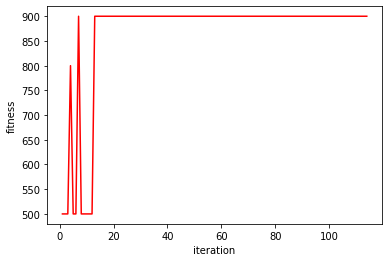

In [ ]:
chromosome_length, prices, values, distances, value_decrease_rates, available_money = read_input()
fitness, solution, fitness_history, solution_history = Genetic_Algorithm(chromosome_length, prices, values, distances, value_decrease_rates, available_money)
print('solution: ', solution, 'fitness: ', fitness)

plt.plot(range(1, len(fitness_history)+1), fitness_history, 'r-')
plt.ylabel('fitness')
plt.xlabel('iteration')
plt.show()